# Temporal Fusion Transformer (TFT) Forecast

**Goal:**  
Utilize the Temporal Fusion Transformer to forecast the daily german energy consumption in 2019 
 - Evaluation type: Offline / historical backtest  
 - Metric focus: MAE, RMSE, MAP 

**MLflow server:** 
mlflow server --backend-store-uri sqlite:///mlflow.db --host 127.0.0.1 --port 8080

**Author:** Rodrigo Amorim

## Import the necessary libraries and load the dataset


In [3]:
# Import required libraries 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import optuna 
import mlflow 


from sklearn.metrics import (
mean_absolute_error,
root_mean_squared_error,
mean_absolute_percentage_error
)
from pytorch_forecasting import (
TimeSeriesDataSet,
TemporalFusionTransformer,
QuantileLoss,
MAE
)
from lightning.pytorch import Trainer
from pytorch_lightning.callbacks import EarlyStopping


In [4]:
# Set the tracking uri and give a name to the experiment (MLflow set up)
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("TFT_EnergyPrediction_ExP")

2025/12/25 09:49:46 INFO mlflow.tracking.fluent: Experiment with name 'TFT_EnergyPrediction_ExP' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/5', creation_time=1766656186988, experiment_id='5', last_update_time=1766656186988, lifecycle_stage='active', name='TFT_EnergyPrediction_ExP', tags={}>

In [5]:
# Import the processed dataset
df = pd.read_parquet(r'C:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\Data\Processed/GermanEnergyConsumption.parquet')

In [6]:
# Prepare the data for the TFT model 
# The model requires a column called "time" that contains the timestamps 
df = df.reset_index()
df.rename(columns= {"Date" : "time"}, inplace = True)

# Since the TFT model only works with integer time index, we need to create it 
df["time_idx"] = (df["time"] - df["time"].min()).dt.total_seconds() // 3600
df["time_idx"] = pd.to_numeric(df["time_idx"], downcast = "integer")  # Convert to integer type

# Creating time features 
df["hour"] = df["time"].dt.hour
df["dayofweek"] = df["time"].dt.dayofweek 

# Defining a group ID (Necessary for the TFT model)
df["series_id"] = "DE"

In [7]:
# Train / Test Split 
max_prediction_length = 24 # Predict the next 24 hours of energy consumption 
max_encoder_length = 168 # Only uses the previous week information 

train_split = df["time_idx"].max() - 24 * 730 # Use the data from 2015 - 2017
val_split = df["time_idx"].max() - 24 * (365 + 7) # 2018 (Minus 1 week to allow for correct predictions in the test set)

# Train set
train = TimeSeriesDataSet(
    df[df["time_idx"] <= train_split],
    time_idx = "time_idx",
    target = "DE_Load",
    group_ids = "series_id",
    max_encoder_length = max_encoder_length,
    max_prediction_length = max_prediction_length,
    time_varying_known_reals = ["time_idx", "hour", "dayofweek"],
    time_varying_unknown_reals = ["DE_Load"], 
    )

# Val set 
val = TimeSeriesDataSet.from_dataset(
    train,
    df[(train_split < df["time_idx"]) & (df["time_idx"] <= val_split)],
    predict = True,
    stop_randomization = True,
)

# Loading the data 
train_loader = train.to_dataloader(train = True, batch_size = 20)
val_loader = val.to_dataloader(train = False, batch_size = 1) # Only one prediction 


## Hyperparameter tuning with Optuna

In [ ]:
# Hyperparameter Tuning using Optuna
def objective(trial):
    # List of Hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 32, 64)
    attention_head_size = trial.suggest_int("attention_head_size", 1, 8)
    dropout = trial.suggest_float("dropout", 0.1, 0.4)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 5e-3)
    hidden_continuous_size = trial.suggest_int("hidden_continuous_size", 8,32)

    # Model
    model = TemporalFusionTransformer.from_dataset(
        train,
        hidden_size = hidden_size,
        attention_head_size = attention_head_size,
        dropout = dropout,
        hidden_continuous_size = hidden_continuous_size,
        learning_rate = learning_rate, 
        log_interval = 10,
        loss = QuantileLoss(),
        reduce_on_plateau_patience = 4,
    )
    
    trainer = Trainer(
        max_epochs = 2,
        accelerator = "cpu",
        enable_checkpointing = False,
        logger = False,
        callbacks = [
            EarlyStopping(monitor = "val_loss", patience = 4, mode = "min")
        ]
    )

    trainer.fit(model, train_loader, val_loader)

    return trainer.callback_metrics["val_loss"].item()

study = optuna.create_study(direction = "minimize", study_name = "TFT Hyperparameter Tuning")
study.optimize(objective, n_trials = 10) # A smaller number of trials was selected due to limited computational resources

[I 2025-12-24 16:02:39,807] A new study created in memory with name: TFT Hyperparameter Tuning
C:\Users\rodri\AppData\Local\Temp\ipykernel_15208\2059046596.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 5e-3)
c:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` 

c:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1305/1305 [03:36<00:00,  6.03it/s, train_loss_step=1.34e+3, val_loss=1.03e+4, train_loss_epoch=1.27e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1305/1305 [03:36<00:00,  6.03it/s, train_loss_step=1.34e+3, val_loss=1.03e+4, train_loss_epoch=1.27e+3]

[I 2025-12-24 16:09:29,131] Trial 0 finished with value: 10311.9716796875 and parameters: {'hidden_size': 35, 'attention_head_size': 1, 'dropout': 0.2990383902817371, 'learning_rate': 0.00013774534442803778, 'hidden_continuous_size': 13}. Best is trial 0 with value: 10311.9716796875.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 88     | train | 0    
4  | static_variable_selection         


Epoch 1: 100%|██████████| 1305/1305 [03:36<00:00,  6.04it/s, train_loss_step=935.0, val_loss=8.77e+3, train_loss_epoch=1.19e+3]  

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1305/1305 [03:36<00:00,  6.04it/s, train_loss_step=935.0, val_loss=8.77e+3, train_loss_epoch=1.19e+3]

[I 2025-12-24 16:17:07,720] Trial 1 finished with value: 8771.4970703125 and parameters: {'hidden_size': 46, 'attention_head_size': 5, 'dropout': 0.3770772543328047, 'learning_rate': 0.00013880556604613435, 'hidden_continuous_size': 11}. Best is trial 1 with value: 8771.4970703125.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 144    | train | 0    
4  | static_variable_selection          |


Epoch 1: 100%|██████████| 1305/1305 [04:24<00:00,  4.93it/s, train_loss_step=1.02e+3, val_loss=7.57e+3, train_loss_epoch=983.0]  

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1305/1305 [04:24<00:00,  4.93it/s, train_loss_step=1.02e+3, val_loss=7.57e+3, train_loss_epoch=983.0]

[I 2025-12-24 16:25:50,091] Trial 2 finished with value: 7565.74560546875 and parameters: {'hidden_size': 61, 'attention_head_size': 6, 'dropout': 0.22076193508857408, 'learning_rate': 0.00019847557728568276, 'hidden_continuous_size': 18}. Best is trial 2 with value: 7565.74560546875.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 96     | train | 0    
4  | static_variable_selection        


Epoch 1: 100%|██████████| 1305/1305 [04:24<00:00,  4.93it/s, train_loss_step=822.0, val_loss=4.38e+3, train_loss_epoch=861.0]   

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1305/1305 [04:24<00:00,  4.93it/s, train_loss_step=822.0, val_loss=4.38e+3, train_loss_epoch=861.0]

[I 2025-12-24 16:34:39,310] Trial 3 finished with value: 4380.9541015625 and parameters: {'hidden_size': 57, 'attention_head_size': 5, 'dropout': 0.3403932008249872, 'learning_rate': 0.003602641768314659, 'hidden_continuous_size': 12}. Best is trial 3 with value: 4380.9541015625.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 120    | train | 0    
4  | static_variable_selection          | V


Epoch 1: 100%|██████████| 1305/1305 [04:39<00:00,  4.67it/s, train_loss_step=583.0, val_loss=7.04e+3, train_loss_epoch=818.0]    

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1305/1305 [04:39<00:00,  4.67it/s, train_loss_step=583.0, val_loss=7.04e+3, train_loss_epoch=818.0]

[I 2025-12-24 16:43:55,658] Trial 4 finished with value: 7044.861328125 and parameters: {'hidden_size': 58, 'attention_head_size': 7, 'dropout': 0.1220969525449456, 'learning_rate': 0.0006478339799974819, 'hidden_continuous_size': 15}. Best is trial 3 with value: 4380.9541015625.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 176    | train | 0    
4  | static_variable_selection          | V


Epoch 1: 100%|██████████| 1305/1305 [04:09<00:00,  5.23it/s, train_loss_step=685.0, val_loss=5.59e+3, train_loss_epoch=823.0]   

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1305/1305 [04:09<00:00,  5.23it/s, train_loss_step=685.0, val_loss=5.59e+3, train_loss_epoch=823.0]

[I 2025-12-24 16:52:14,632] Trial 5 finished with value: 5585.21240234375 and parameters: {'hidden_size': 39, 'attention_head_size': 4, 'dropout': 0.19783053105551818, 'learning_rate': 0.004643424709572156, 'hidden_continuous_size': 22}. Best is trial 3 with value: 4380.9541015625.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 128    | train | 0    
4  | static_variable_selection          |


Epoch 1: 100%|██████████| 1305/1305 [04:06<00:00,  5.29it/s, train_loss_step=955.0, val_loss=3.32e+3, train_loss_epoch=880.0]    

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1305/1305 [04:06<00:00,  5.29it/s, train_loss_step=955.0, val_loss=3.32e+3, train_loss_epoch=880.0]

[I 2025-12-24 17:00:28,660] Trial 6 finished with value: 3315.2373046875 and parameters: {'hidden_size': 61, 'attention_head_size': 1, 'dropout': 0.3984905508683332, 'learning_rate': 0.0021649260537111143, 'hidden_continuous_size': 16}. Best is trial 6 with value: 3315.2373046875.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 72     | train | 0    
4  | static_variable_selection          | 


Epoch 1: 100%|██████████| 1305/1305 [03:43<00:00,  5.83it/s, train_loss_step=606.0, val_loss=6.03e+3, train_loss_epoch=865.0]    

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1305/1305 [03:43<00:00,  5.83it/s, train_loss_step=606.0, val_loss=6.03e+3, train_loss_epoch=865.0]

[I 2025-12-24 17:08:18,509] Trial 7 finished with value: 6026.544921875 and parameters: {'hidden_size': 49, 'attention_head_size': 8, 'dropout': 0.32000139041811315, 'learning_rate': 0.0012254374881415753, 'hidden_continuous_size': 9}. Best is trial 6 with value: 3315.2373046875.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 144    | train | 0    
4  | static_variable_selection          | V


Epoch 1: 100%|██████████| 1305/1305 [04:30<00:00,  4.82it/s, train_loss_step=906.0, val_loss=3.28e+3, train_loss_epoch=852.0]    

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1305/1305 [04:30<00:00,  4.82it/s, train_loss_step=906.0, val_loss=3.28e+3, train_loss_epoch=852.0]

[I 2025-12-24 17:17:00,149] Trial 8 finished with value: 3283.695068359375 and parameters: {'hidden_size': 57, 'attention_head_size': 5, 'dropout': 0.38554211367405145, 'learning_rate': 0.0011833254693198643, 'hidden_continuous_size': 18}. Best is trial 8 with value: 3283.695068359375.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 0      | train | 0    
3  | prescalers                         | ModuleDict                      | 240    | train | 0    
4  | static_variable_selection       


Epoch 1: 100%|██████████| 1305/1305 [04:41<00:00,  4.63it/s, train_loss_step=878.0, val_loss=3.35e+3, train_loss_epoch=1.03e+3]  

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1305/1305 [04:41<00:00,  4.63it/s, train_loss_step=878.0, val_loss=3.35e+3, train_loss_epoch=1.03e+3]

[I 2025-12-24 17:26:24,987] Trial 9 finished with value: 3350.359375 and parameters: {'hidden_size': 62, 'attention_head_size': 7, 'dropout': 0.12729691232975077, 'learning_rate': 0.0001756462344749821, 'hidden_continuous_size': 30}. Best is trial 8 with value: 3283.695068359375.


In [ ]:
# Identiftying the best parameters 
print("Best Trial:")
print(study.best_trial.params)

best_parameters = study.best_trial.params
best_parameters["loss"] = QuantileLoss()
best_parameters["log_interval"] = 10
best_parameters["reduce_on_plateau_patience"] = 4 



Best Trial:
{'hidden_size': 57, 'attention_head_size': 5, 'dropout': 0.38554211367405145, 'learning_rate': 0.0011833254693198643, 'hidden_continuous_size': 18}


## Train the model with the best found hyperparameters 

In [ ]:
# Train the final version of the TFT

# Create the model
final_model = TemporalFusionTransformer.from_dataset(
        train,
        **best_parameters
)

# Utilize the initial train + val sets for training (To ensure a more fair comparison with the XGBoost Model) 
# Full training set 
train_full = TimeSeriesDataSet.from_dataset(
    train,
    df[df["time_idx"] <= val_split],
)

# Loading the data 
train_full_loader = train_full.to_dataloader(train = True, batch_size = 20)

# Create the Trainer 
trainer = Trainer(
    max_epochs = 8,
    accelerator = "cpu",
    enable_checkpointing = False,
    logger = False,
    
    #callbacks = [  
    #    EarlyStopping(monitor = "val_loss", patience = 3, mode = "min")
    #],  
)

# Train the model 
trainer.fit(final_model, train_full_loader)

# Store the model with MLflow
with mlflow.start_run(run_name = "TFT_Final_Model"):

    # Save the parameters
    mlflow.log_param("model_name", "TFT_Final_Model")
    mlflow.log_params(best_parameters)

    # Save the model
    mlflow.pytorch.log_model(pytorch_model = final_model)

c:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
c:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\.venv\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val

Epoch 1:   0%|          | 0/1735 [00:00<?, ?it/s, train_loss_step=1.09e+3, train_loss_epoch=1.42e+3]           

c:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\.venv\Lib\site-packages\lightning\pytorch\loops\training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 7: 100%|██████████| 1735/1735 [05:49<00:00,  4.97it/s, train_loss_step=509.0, train_loss_epoch=625.0]    

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 1735/1735 [05:49<00:00,  4.97it/s, train_loss_step=509.0, train_loss_epoch=625.0]
🏃 View run TFT_Final_Model at: http://127.0.0.1:8080/#/experiments/5/runs/d956208e94c048b2b2ef43fda3e2d3a6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/5


In [ ]:
# Loading the previsouly trained model 
model = mlflow.pytorch.load_model(model_uri="")

## Make the rolling 24h window predictions and compute the performance metrics 

In [ ]:
# Make the final predictions (rolling 24h window)

rol_predictions = []
pred_timestamps = []

raw_outputs = []
x_outputs = []

test_df = df[df["time_idx"] > val_split]

for start_idx in range(0, len(test_df) -  max_encoder_length - max_prediction_length + 1, max_prediction_length):

    cut_off = val_split + start_idx + max_encoder_length + max_prediction_length
    decoder_start = val_split + start_idx + max_encoder_length

    test_window = TimeSeriesDataSet.from_dataset(
        train,
        df[df["time_idx"] < cut_off],
        predict = True,
        stop_randomization = True,  
    )

    loader = test_window.to_dataloader(train = False, batch_size = 1, shuffle = False, num_workers = 4, persistent_workers=True)
    pred_timestamps.append(df.loc[decoder_start:cut_off-1, "time"].values)
    
    # Predictions 
    pred = final_model.predict(loader, mode = "prediction")
    out = final_model.predict(loader, mode = "raw", return_x = True)

    raw = out[0]
    x = out[1]

    # store raw and x for later interpretability analysis 
    raw_outputs.append(raw)
    x_outputs.append(x)

    rol_predictions.append(pred.detach().cpu().numpy().flatten())

y_pred_TFT = np.concatenate(rol_predictions)
pred_timestamps_TFT = np.concatenate(pred_timestamps)

c:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
# Calculate the performance metrics

# True values 
split = df["time_idx"].max() - 24*(365) # Data from 2019 
test2_df = df[df["time_idx"] > split]
y_true = test2_df["DE_Load"]

# Compute the relevant metrics
mae = mean_absolute_error(y_true, y_pred_TFT)
rmse = root_mean_squared_error(y_true, y_pred_TFT)
map = mean_absolute_percentage_error(y_true, y_pred_TFT)

print(f"Rolling 24h MAE (full year): {mae:.2f}")
print(f"Rolling 24h RMSE (full year): {rmse: .2f}")
print(f"Rolling 24h MAP (full year): {map: .2f}")


Rolling 24h MAE (full year): 2327.10
Rolling 24h RMSE (full year):  3232.66
Rolling 24h MAP (full year):  0.04


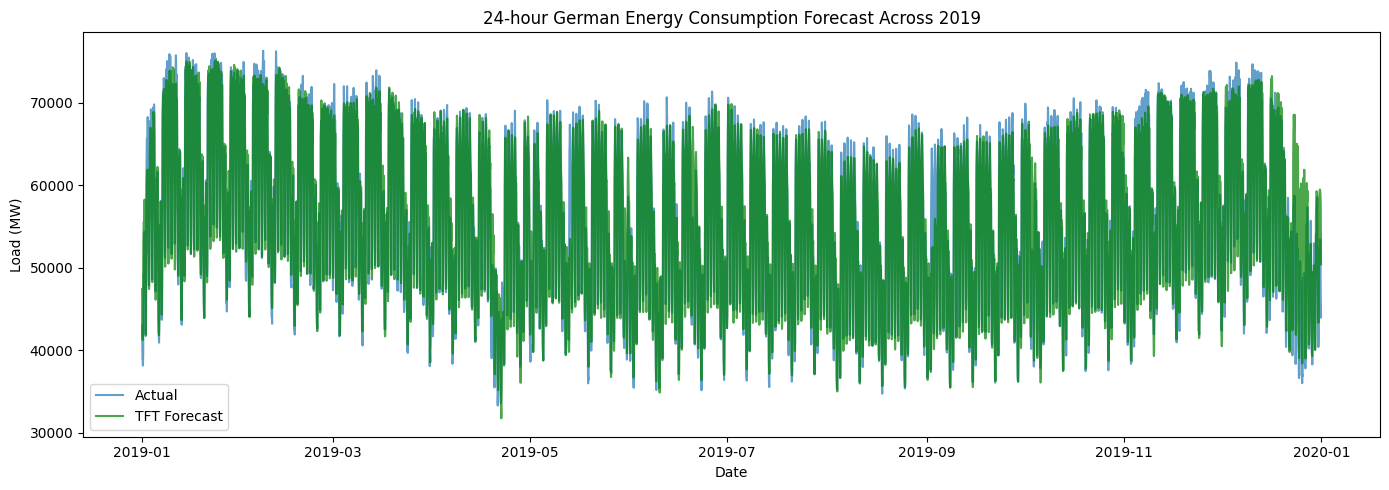

In [ ]:
# Plots
plt.figure(figsize=(14, 5))
plt.plot(pred_timestamps_TFT, y_true, label="Actual", alpha=0.7)
plt.plot(pred_timestamps_TFT, y_pred_TFT, label="TFT Forecast", alpha=0.7, color = "green")
plt.legend()
plt.title("24-hour German Energy Consumption Forecast Across 2019")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.tight_layout()
plt.show()

**Analysis:**

The Temporal Fusion Transformer demonstrates a strong ability to capture the dominant daily and weekly seasonal patterns in German electricity consumption, as evidenced by the close alignment between predicted and actual load profiles throughout 2019. In terms of performance metrics, the model achieves a rolling 24-hour MAE of 2327 MW and a MAPE of approximately 4%, indicating competitive performance in the prediction of german electiricty prediction. 

Overall, the results confirm that explicitly encoding daily and weekly seasonality is crucial for accurate load forecasting, and that while TFT provides a robust and interpretable forecasting framework, its performance can be further improved through more extensive hyperparameter tuning or adaptive retraining strategies.

In [ ]:
# Interpretability 
interpretations = [
    final_model.interpret_output(raw, reduction = "mean")
    for raw in raw_outputs
]

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x200 with 1 Axes>,
 'encoder_variables': <Figure size 700x300 with 1 Axes>,
 'decoder_variables': <Figure size 700x275 with 1 Axes>}

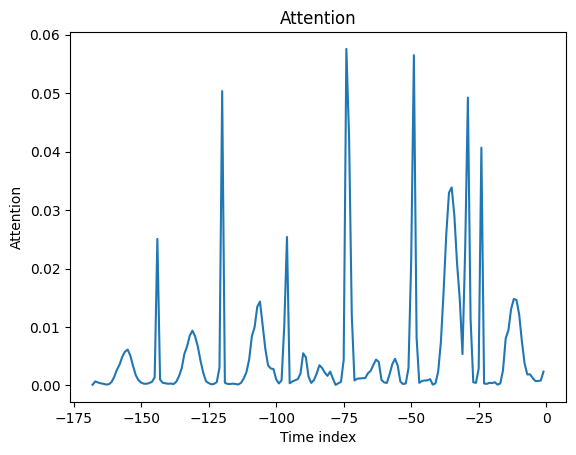

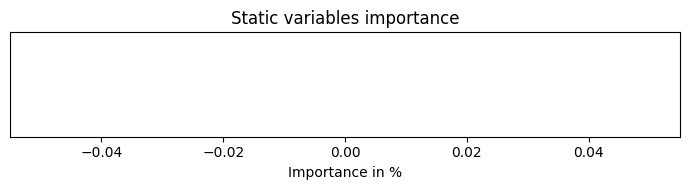

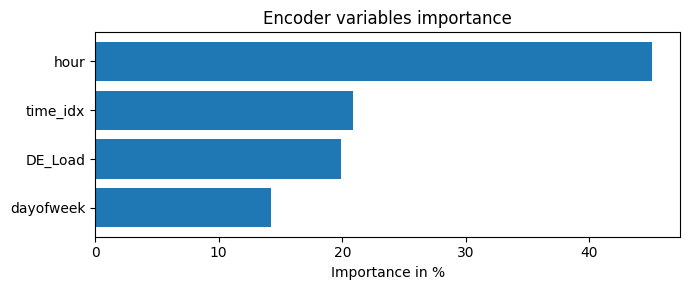

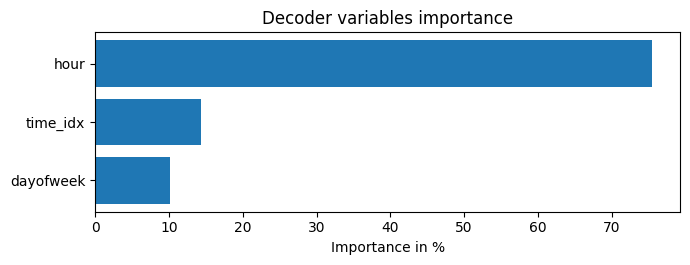

In [ ]:
# Plot the respective Interpretability figures (For the 50th rolling window)
final_model.plot_interpretation(interpretations[50])

**Analysis:** 

From the above plots it is clear that the hour variable presented itself as the most import feature in both the encoder and decoder, demonstrating its necessity once again to accurately model the underlying temporal structure of the electricity demand in Germany. 

In [ ]:
# Save the results into MLflow for the final comparison 

with mlflow.start_run(run_name = "TFT_Results"):

    # Save the data first
    np.save("y_pred_TFT.npy", y_pred_TFT)
    mlflow.log_artifact("y_pred_TFT.npy")

🏃 View run TFT_Results at: http://127.0.0.1:8080/#/experiments/5/runs/023634ca5c5e4d2bbffbc79a069ddbde
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/5
